In [1]:
from ipywidgets import interact, interact_manual

# %load_ext autoreload
# %autoreload 2

In [2]:
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

In [3]:
import yaml

with open("../config.yml", 'r') as f:
    cfg = yaml.safe_load(f)

# Convolutional Neural Tangent Kernels

Various papers have shown that, in the infinite width limit, any _Neural Network_ with _standard architecture_ is equivalent to a Gaussian process at initialization. Furthermore, Jacot and Al. have introduced the concept of _Neural Tangent Kernel_ and proved that for MLP, it stays constant during training.

Although, for MLPs, regression based on NTK obtains results equivalent, or even better, than those of the original network, the same does not holds for CNNs, where experimental results show that the actual network greatly outperform the kernel methods.

We investigate in this notebook the reason for that behaviour. In particular, we focus on what the network is actually learning, to confront it with what the NTK gives as a function.

## The experiment

We consider different network architectures and, for each, we study the learning of a Neural Network $NN$ randomly initialized.
It is proved in [yang2019scaling] that, in the infinite width limit (IWL), each such Network is equivalent at initialization to a Gaussian Precess.
Furthermore, [jacot2019neural] proved that in the MLP case during training, the gradient follow the Neural Tangent Kernel, which in the IWL is constant and converges.
We conjecture that the same should hold for any architecture and study what the actual Net learns compared to the infinite width limit.

In particular, we consider for each $NN$ at initialization, the actual Neural Tangent Kernel $$???$$ which we denote by $NTK^P_0$ and its theoretical-infinite-wide counterpart $NTK^\infty$.

We then train the Net to get $NN_\infty$ and its corresponding $NTK^P_\infty$.
By [jacot2019neural], we know that $NTK^\infty$ does not change during training, so we can study the kernel regression functions $f^P_\infty$ and $f^\infty$ given respectively by the finite-case Tangent Kernel and the infinte-width one.
Note that the subscript $\infty$ refers to the training, while the superscript one refers to the number of parameters.

We expect the $f^M_\infty$ to be very close to the actual Net output $NN_\infty$ and we want to understand the difference between it and the infinite width kernel regression function.

We use **Pythorch** as our deep learning framework.

In [4]:
# warnings.simplefilter('ignore')

import torch
import torchvision

import torch.nn as nn
import torch.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.autonotebook import tqdm

from utility.util import one_hot
from utility.train import train
from utility.metrics import print_score, nn_accuracy_score
from utility.torchKernel import NeuralTangentKernel

/home/william/.local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
seed = cfg['other']['random_seed']

torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## The dataset

To start, we work with the **MNIST** dataset, to investigate what the CNN kernel learns. When working with transformers we will use a semantic dataset **TBD**

The MNIST dataset consist in grayscale images of handwritten digits, whose size is 28x28 pixels.

We use 1000 samples for train and we study the Kernel on a test of 100 samples, representing each class (digit).

In [6]:
train_size = cfg['dataset']['train_size']
test_size = cfg['dataset']['test_size']

In [7]:
transform =torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,))
                  ])

In [8]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(cfg['dataset']['path'], train=True, download=True,
                             transform=transform),
  batch_size=train_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(cfg['dataset']['path'], train=False, download=True,
                             transform=transform),
  batch_size=test_size, shuffle=True)

Note that the values $0.1307$ and $0.3081$ are the well known mean and variance for the MNIST dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


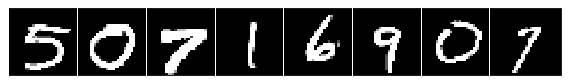

    5     0     7     1     6     9     0     7


In [9]:
def imshow(img):
    img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.figure(figsize = (8,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks(ticks=[i*30 for i in range(8)], labels=[])
    plt.yticks(ticks=[0,30], labels=[])
    plt.tight_layout()
    if False:
        plt.savefig(cfg['figures']['path']+'/mnist_sample.png', bbox='tight')
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

ordered_labels = labels.argsort()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))

In [10]:
testiter = iter(test_loader)
images_test, labels_test = testiter.next()

## Convolutional Network

We use a simple design, to warm up the computations. The derivation of the NTK is then based on [arora2019exact].

We use an MLP with ? layers and ReLU activation function, and try a different number of hidden nodes.

In [11]:
n_channels = 20
CNN = nn.Sequential(nn.Conv2d(1,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels, 10, 20), nn.Flatten())

CNN_t = nn.Sequential(nn.Conv2d(1,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels,n_channels,5), nn.ReLU(),
                    nn.Conv2d(n_channels, 10, 20), nn.Flatten())

In [12]:
def count_params(net):
    return sum(par.numel() for par in net.parameters() if par.requires_grad)

In [13]:
count_params(CNN_t)

90550

In [14]:
%%time
CNTK_p = NeuralTangentKernel(images, CNN, verbose=True, device=device)


Computed jacobians in 1040.656769990921s
CPU times: user 12min 58s, sys: 4min 11s, total: 17min 10s
Wall time: 17min 21s


In [15]:
# optimizer = torch.optim.SGD(CNN_t.parameters(), lr=0.001)
optimizer = torch.optim.Adam(CNN_t.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
train(CNN_t, images, labels, criterion, optimizer, nb_epochs=5000, device=device)

print_score(CNN_t, criterion, images, labels, images_test, labels_test, device=device)
print_score(CNN_t, nn_accuracy_score, images, labels, images_test, labels_test, device=device)


Train score : tensor(2.4772e-07, device='cuda:0', grad_fn=<NllLossBackward>)
CrossEntropyLoss() on TRAIN :	 2.4771691187197575e-07 
CrossEntropyLoss() on TEST :	 0.9112668037414551
<function nn_accuracy_score at 0x7fee99e258c0> on TRAIN :	 1.0 
<function nn_accuracy_score at 0x7fee99e258c0> on TEST :	 0.8940000534057617


In [16]:
if next(CNN_t.parameters()).is_cuda:
    CNN_t = CNN_t.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


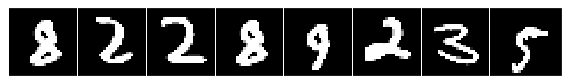

Label :		 8 2 2 8 9 2 3 5
Prediction :	 8 2 2 8 9 2 3 5


In [17]:
random_idcs = [np.random.randint(100) for _ in range(8)]
# show images
imshow(torchvision.utils.make_grid(images[random_idcs].cpu()))
# print labels
print('Label :\t\t', *(labels[j].item() for j in random_idcs))
print('Prediction :\t', *(CNN_t(images)[j].argmax().item() for j in random_idcs))

In [18]:
CNTK_t = NeuralTangentKernel(images, CNN_t, device=device)

In [19]:
digits = [1,3,17,15,9,0,4,2,24,5]

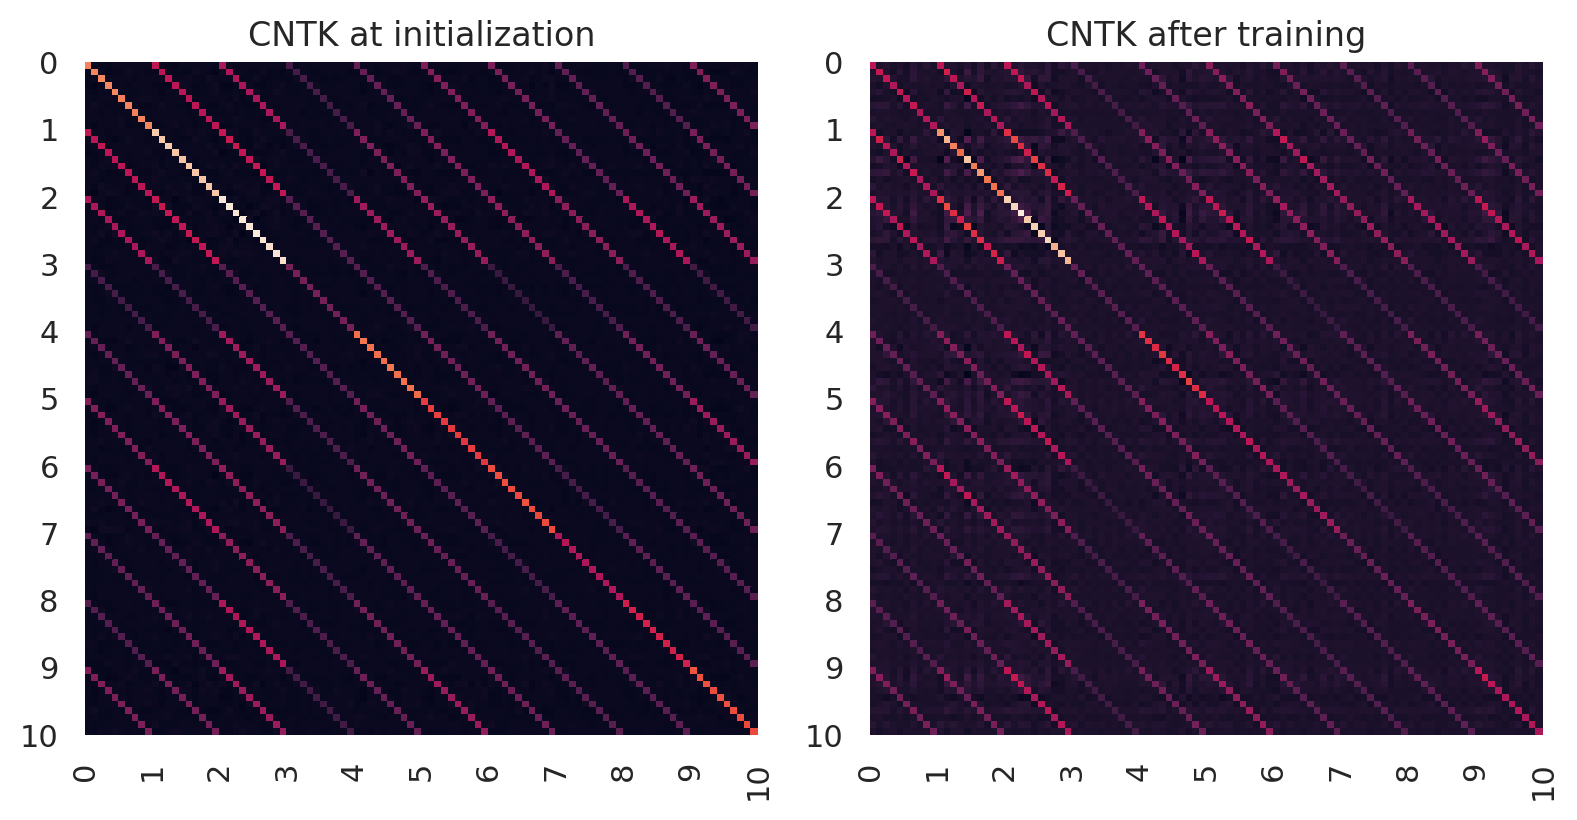

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


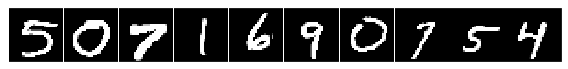

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), dpi=200)
sns.heatmap(CNTK_p.kernel[:100,:100].cpu(), ax=ax1, cbar=False, square=True)
sns.heatmap(CNTK_t.kernel[:100,:100].cpu(), ax=ax2, cbar=False, square=True)
ax1.set(title='CNTK at initialization', xticks=[10*i for i in range(11)], xticklabels=[i for i in range(11)],
        yticks=[10*i for i in range(11)], yticklabels=[i for i in range(11)])
ax2.set(title='CNTK after training', xticks=[10*i for i in range(11)], xticklabels=[i for i in range(11)],
        yticks=[10*i for i in range(11)], yticklabels=[i for i in range(11)])
plt.tight_layout()
plt.savefig(cfg['figures']['path']+'/cntk_before_after_tr.png', bbox='tight')
plt.show()

imshow(torchvision.utils.make_grid(images[:10].cpu(), nrow=10))

In [21]:
optimizer = torch.optim.Adam(CNTK_p.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
train(CNTK_p, images, labels, criterion, optimizer, nb_epochs=5000, device=device)


Train score : tensor(2.5844, device='cuda:0', grad_fn=<NllLossBackward>)


NeuralTangentKernel()

In [22]:
%%time
CNTK_p.train(False)
pred_te_0 = CNTK_p(images_test)


CPU times: user 14min 57s, sys: 4min 6s, total: 19min 3s
Wall time: 17min 30s


In [31]:
CNTK_t.train(True)
pred_tr = CNTK_t(images)

In [32]:
nn_accuracy_score(pred_tr.cpu(), labels.cpu())

tensor(1.)

In [23]:
nn_accuracy_score(pred_te_0.cpu(), labels_test.cpu())

tensor(0.8020)

In [24]:
optimizer = torch.optim.Adam(CNTK_t.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
train(CNTK_t, images, labels, criterion, optimizer, nb_epochs=5000, device=device)


Train score : tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


NeuralTangentKernel()

In [25]:
%%time
CNTK_t.train(False)
pred_te_inf = CNTK_t(images_test)


CPU times: user 15min 2s, sys: 4min 7s, total: 19min 9s
Wall time: 17min 39s


In [26]:
nn_accuracy_score(pred_te_inf.cpu(), labels_test.cpu())

tensor(0.8400)